# Acquiring the data

In [1]:
from src.client import ConfigClient, DataClient

# Build configurations
configs = ConfigClient(["config"]).build()

# Get a data client
client = DataClient(configs=configs)

In [2]:
import pandas as pd
from datetime import datetime

# Get the products data
products_df = client.products_df
products_df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


# Processing data

In [3]:
# Feature and label columns
label_col = 'category'
feature_cols = products_df.columns.tolist()
feature_cols.remove(label_col)

# Build label and features dataframes
labels, features = products_df[label_col], products_df[feature_cols]

In [4]:
from sklearn.model_selection import train_test_split

# Segregate train and test data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=30, stratify=labels)

## Process features

In [5]:
from src.pipe.base import (TextProcessing, 
                           DateProcessing, 
                           OverallProcessing)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Creating the data processing pipeline
pipe = Pipeline([
    ("text_processing", TextProcessing()),
    ("date_processing", DateProcessing()),
    ("overall_processing", OverallProcessing()),
    ("dimension_reduction", PCA(n_components=250)),
    ("starndarization", StandardScaler()),
], verbose=True)

In [6]:
X_ = pipe.fit_transform(X_train.copy())

[Pipeline] ... (step 1 of 5) Processing text_processing, total=   9.0s
[Pipeline] ... (step 2 of 5) Processing date_processing, total=   3.7s
[Pipeline]  (step 3 of 5) Processing overall_processing, total=   0.8s
[Pipeline]  (step 4 of 5) Processing dimension_reduction, total= 1.2min
[Pipeline] ... (step 5 of 5) Processing starndarization, total=   0.1s


## Processing labels

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_ = le.fit_transform(y_train)

## Resample data

In [8]:
from imblearn.over_sampling import SMOTE

X_res, y_res = SMOTE().fit_resample(X_, y_)

# Train model

In [9]:
import timeit
from sklearn.ensemble import RandomForestClassifier

tic = timeit.default_timer()
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15
)

clf.fit(X_res, y_res)

toc = timeit.default_timer()
print(f"Training time: {round(toc - tic, 2)} seconds")

Training time: 257.01 seconds


# Testing model

In [10]:
# Encode testing labels
y_proc_test = le.transform(y_test)

# Process testing data
X_proc_test = pipe.transform(X_test.copy())

# Predict output data
y_hat = clf.predict(X_proc_test)

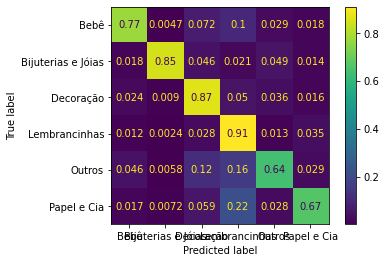

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cmat = confusion_matrix(y_proc_test, y_hat, normalize='true')
cm_display = ConfusionMatrixDisplay(cmat, display_labels=le.inverse_transform(clf.classes_)).plot()

# Exporting data

In [12]:
import joblib 

joblib.dump(pipe, "./data/models/pipeline.joblib")
joblib.dump(le, "./data/models/label_encoder.joblib")
joblib.dump(clf, "./data/models/model.joblib")

['./data/models/model.joblib']